model_prelim_2

17:27 NOV 2017 -- Wayne H Nixalo

## Statoil Iceberg Classification Competition

---

Test notebook to check I can get data loaded into a model via fastai's API.

### Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# All main external libraries
from fastai.imports import *

In [3]:
# Other direct imports
from fastai.model import *
from fastai.dataset import *
from fastai.conv_learner import *

### Directories

In [4]:
PATH='data/'; TRAIN='train/'; VALID='valid/'; TEST='test/'; CATS=['ship/','ice/']

In [5]:
# building directory structure
DIRS = [TRAIN, VALID, TEST]
for dr in DIRS:
    if not os.path.exists(PATH + dr):
        os.mkdir(PATH + dr)
    # building category folders
    for cat in CATS:
        if dr != TEST and not os.path.exists(PATH + dr + cat):
            os.mkdir(PATH + dr + cat)

In [6]:
def ResetROOT():
    """Sets the current working directory to project root. NOTE no trailing '/'"""
    # set ROOT to project dirs absolute path
    ROOT = os.path.expanduser('~/iceberg')
    # if current dir Not ROOT: set to ROOT
    if os.getcwd() != ROOT:
        %cd $ROOT

def ClearDirs():
    """Erases all files and foldiers in the TRAIN, TEST, and VALID paths."""
    # check path vars were defined:
    if not (PATH and TEST and TRAIN and VALID):
        print("Path variables not yet defined. Quitting.")
        return
    # ensure start at ROOT
    ResetROOT()
    # erase all files/folders
    %rm -r $PATH$TEST*
    %rm -r $PATH$TRAIN*
    %rm -r $PATH$VALID*

In [7]:
ClearDirs()

rm: cannot remove 'data/test/*': No such file or directory


### Data

**NOTE**: from some testing: reading data from a `.json` file using the `json` library repeatdely, (that is, redefining a variable multiple times) does *NOT* cause an increase in RAM usage. Using `pandas.read_json(..)` will increase RAM usage without freeing previously allocated data.

In [8]:
# Load data from .json files w/ Pandas
# train_data = pd.read_json(PATH+'train.json')
# test_data  = pd.read_json(PATH+'test.json')

# Load data from .json files w/ json
with open(PATH+'train.json') as jsonfile:
    train_data = json.load(jsonfile)
    
with open(PATH+'test.json') as jsonfile:
    test_data  = json.load(jsonfile)

**NOTE** If taking the `json` route to unpacking the data instead of `Pandas`:

The `pandas` read data will retain its original indexing. So here specifying `train_data['band_1']` will give you an array of all `band_1` images in the dataset.

This will *NOT* work if loading via `json`. In this case, the data will be loaded as an array of dictionaries. `train_data[0]['band_1']` will return the `band_1` image of the 1st indexed data element.

In [9]:
# Build data arrays as 3D tensors for the model (Assumes loaded via json)
band_1 = [np.array(datum['band_1']).astype(np.float32).reshape(75,75) for datum in train_data]
band_2 = [np.array(datum['band_2']).astype(np.float32).reshape(75,75) for datum in train_data]
band_1 = np.array(band_1)
band_2 = np.array(band_2)

In [10]:
# Build 3rd channel as a composite of the HH/HV bands (This is smth to Tweak)
train_data_array = np.concatenate([band_1[:,:,:,np.newaxis], 
                                   band_2[:,:,:,np.newaxis], 
                                   ((band_1 + band_2)/2)[:,:,:,np.newaxis]], 
                                  axis=-1)

In [11]:
# ImageClassifierData.from_arrays(..) expects 2nd dim idx to be num_channels
train_data_array = np.rollaxis(train_data_array, 3, 1)
train_data_array.shape

(1604, 3, 75, 75)

In [12]:
train_labels_array = np.array([datum['is_iceberg'] for datum in train_data])

In [13]:
# Same as above but for test data:
test_band_1 = [np.array(datum['band_1']).astype(np.float32).reshape(75,75) for datum in test_data]
test_band_2 = [np.array(datum['band_2']).astype(np.float32).reshape(75,75) for datum in test_data]
test_band_1 = np.array(test_band_1)
test_band_2 = np.array(test_band_2)
test_data_array = np.concatenate([test_band_1[:,:,:,np.newaxis],
                                  test_band_2[:,:,:,np.newaxis],
                                  ((test_band_1 + test_band_2)/2)[:,:,:,np.newaxis]],
                                 axis=-1)
test_data_array = np.rollaxis(test_data_array, -1, 1) # channel is last dim, same as '3' above

In [14]:
test_data_array = np.array(test_data_array)

In [15]:
test_data_array.shape

(8424, 3, 75, 75)

### Model Architecture

In [16]:
ARCH = resnet18 # suggested by J.Howard due to small dataset
sz   = 224

In [17]:
# NOTE: test version using all training data as validation as well
resnet_data = ImageClassifierData.from_arrays(os.getcwd()+'/'+PATH, 
                                              (train_data_array, train_labels_array), 
                                              (train_data_array, train_labels_array),
                                              bs=16,
                                              num_workers=4, 
                                              test=test_data_array)

### Learning Rate & Training

**NOTE:** Deleting the `data/tmp/` folder that `ConvLearner` creates allowed me to retrain the model, this time specifying a test data array. See: http://forums.fast.ai/t/imageclassifierdata-from-arrays/7559/21

In [18]:
learn = ConvLearner.pretrained(ARCH, resnet_data, precompute=True)
λrf = learn.lr_find()

100%|██████████| 527/527 [01:34<00:00,  5.67it/s]


 74%|███████▍  | 75/101 [00:00<00:05,  4.81it/s, loss=1.37] 


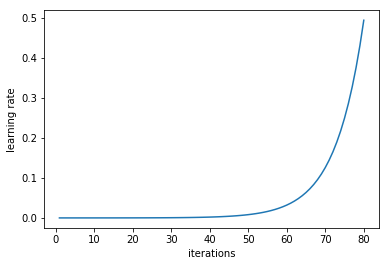

In [19]:
learn.sched.plot_lr()

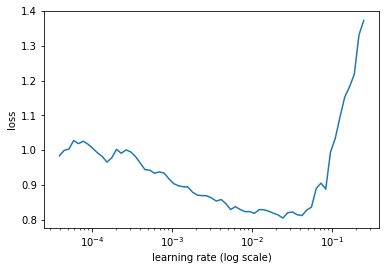

In [20]:
learn.sched.plot()

In [151]:
learn = ConvLearner.pretrained(ARCH, resnet_data, precompute=True)

In [21]:
learn.fit(1.3e-3, 10)

[ 0.       0.58291  0.52183  0.72834]                       
[ 1.       0.57803  0.47986  0.76238]                       
[ 2.       0.56517  0.47398  0.76299]                       
[ 3.       0.57013  0.45542  0.79765]                       
[ 4.       0.54549  0.45272  0.7729 ]                       
[ 5.       0.53405  0.44699  0.7896 ]                       
[ 6.       0.50789  0.44563  0.7828 ]                       
[ 7.       0.5078   0.42843  0.79022]                       
[ 8.       0.5106   0.44705  0.77846]                       
[ 9.       0.49923  0.42288  0.80012]                       



### Differential Learning Rate & Training

In [49]:
learn.precompute = False
learn.fit(1.3e-3, n_cycle=1, cycle_len=1)

[ 0.       0.46014  0.41783  0.80693]                       



In [50]:
learn.unfreeze()
λr = np.array([1e-3, 3e-3, 9e-3])

In [51]:
learn.fit(λr, n_cycle=3, cycle_len=1, cycle_mult=3)

[ 0.       0.46644  0.27231  0.89047]                        
[ 1.       0.45253  0.33923  0.84901]                        
[ 2.       0.31413  0.11823  0.95978]                        
[ 3.       0.20273  0.09896  0.96968]                        
[ 4.       0.22462  0.21935  0.90161]                        
[ 5.       0.2032   0.07196  0.98205]                        
[ 6.       0.16702  0.04423  0.98824]                        
[ 7.       0.11332  0.02059  0.99505]                        
[ 8.       0.05903  0.00537  0.99938]                         
[ 9.       0.04041  0.00316  0.99938]                        
[ 10.        0.03433   0.00186   1.     ]                    
[ 11.        0.01739   0.00259   1.     ]                     
[ 12.        0.01608   0.00159   1.     ]                     



### Predictions / Submission

In [163]:
# test_preds = learn.predict(is_test=True)
# print(test_preds.shape)

(8424, 2)


In [52]:
# TTA: test time augmentation generates altered vsns of test data & ensembles predictions
test_preds = learn.TTA(is_test=True)

In [53]:
# submisssion
submission = pd.DataFrame()
submission['id'] = [datum['id'] for datum in test_data] #  = test_data['id'] if test_data is pd.DataFrame
submission['is_iceberg'] = pd.DataFrame({'is_iceberg':list(np.exp(test_preds[0][:][:,0]))})

In [54]:
submission.to_csv(PATH+'results/'+'WNIXALO_prelim_model_test_submission.csv', index=False)

In [55]:
submission.head()

,id,is_iceberg
0,5941774d,0.999882
1,4023181e,0.409438
2,b20200e4,0.999038
3,e7f018bb,0.000348
4,4371c8c3,0.960634


In [56]:
for i in range(5):
    print(test_data[i]['id'])

5941774d
4023181e
b20200e4
e7f018bb
4371c8c3


In [57]:
print(test_preds[0][:5][:,0])
print(test_preds[0][:5])
print(np.exp(test_preds[0][:5][:,0]))

[-0.00012 -0.89297 -0.00096 -7.96344 -0.04016]
[[-0.00012 -9.04417]
 [-0.89297 -0.52668]
 [-0.00096 -6.94659]
 [-7.96344 -0.00035]
 [-0.04016 -3.23484]]
[ 0.99988  0.40944  0.99904  0.00035  0.96063]


In [23]:
test_data_array.shape

(8424, 3, 75, 75)

In [28]:
test_data[0]

{'band_1': [-15.863251,
  -15.201077,
  -17.887735,
  -19.172482,
  -15.443275,
  -14.011121,
  -16.124729,
  -17.779478,
  -19.42761,
  -18.219221,
  -17.463379,
  -20.242298,
  -17.672544,
  -16.394279,
  -16.672922,
  -15.948608,
  -17.058884,
  -14.292757,
  -11.704641,
  -12.661265,
  -16.863401,
  -15.360503,
  -14.292401,
  -14.58432,
  -16.960165,
  -18.681437,
  -16.578163,
  -15.861324,
  -15.360004,
  -15.690865,
  -17.359159,
  -19.42597,
  -17.257425,
  -14.809227,
  -15.606586,
  -16.484625,
  -16.484625,
  -17.057457,
  -15.119185,
  -15.946968,
  -17.994354,
  -17.057173,
  -17.156368,
  -14.582966,
  -12.367072,
  -12.600193,
  -12.600121,
  -14.29069,
  -14.884757,
  -15.68951,
  -15.605516,
  -15.946112,
  -18.444817,
  -16.121449,
  -14.434958,
  -16.300404,
  -17.357378,
  -18.329412,
  -20.09778,
  -16.860691,
  -17.155087,
  -19.554522,
  -20.981567,
  -16.4827,
  -14.147083,
  -14.361488,
  -15.521257,
  -16.860121,
  -16.482344,
  -15.03837,
  -14.361134,
  -17